In [3]:
import os
import sys
import glob
import numpy as np

import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

sys.path.append('../../')
import utils.utils as utils
import projects.dsine.config as config
from utils.projection import intrins_from_fov, intrins_from_txt

if __name__ == '__main__':
    device = torch.device('cpu')
    args = config.get_args(test=True)
    assert os.path.exists(args.ckpt_path)

    if args.NNET_architecture == 'v00':
        from models.dsine.v00 import DSINE_v00 as DSINE
    elif args.NNET_architecture == 'v01':
        from models.dsine.v01 import DSINE_v01 as DSINE
    elif args.NNET_architecture == 'v02':
        from models.dsine.v02 as DSINE
    elif args.NNET_architecture == 'v02_kappa':
        from models.dsine.v02_kappa as DSINE
    else:
        raise Exception('invalid arch')

    model = DSINE(args).to(device)
    model = utils.load_checkpoint(args.ckpt_path, model)
    model.eval()

    img_paths = glob.glob('./samples/img/*.hdr') + glob.glob('./samples/img/*.jpg')
    img_paths.sort()

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    with torch.no_grad():
        for img_path in img_paths:
            print(img_path)
            ext = os.path.splitext(img_path)[1]
            img = Image.open(img_path).convert('RGB')
            img = np.array(img).astype(np.float32) / 255.0
            img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)

            # pad input
            _, _, orig_H, orig_W = img.shape
            lrtb = utils.get_padding(orig_H, orig_W)
            img = F.pad(img, lrtb, mode="constant", value=0.0)
            img = normalize(img)

            # get intrinsics
            intrins_path = img_path.replace(ext, '.txt')
            if (os.path.exists(intrins_path)):
                intrins = intrins_from_txt(intrins_path, device=device).unsqueeze(0)
            else:
                intrins = intrins_from_fov(new_fov=60.0, H=orig_H, W=orig_W, device=device).unsqueeze(0)
            intrins[:, 0, 2] += lrtb[0]
            intrins[:, 1, 2] += lrtb[2]

            pred_norm = model(img, intrins=intrins)[-1]
            pred_norm = pred_norm[:, :, lrtb[2]:lrtb[2]+orig_H, lrtb[0]:lrtb[0]+orig_W]

            # Convert pred_norm to a tensor and print its shape
            pred_norm_tensor = pred_norm.detach().cpu()
            print(f"Predicted normals tensor shape: {pred_norm_tensor.shape}")

            # If needed, you can further process or store pred_norm_tensor for later use


/Users/deeven/Desktop/portrait_prj/DSINE-main/projects/dsine
/Users/deeven/Desktop/portrait_prj/DSINE-main/projects/dsine/samples/img/test2.hdr


In [ ]:
import os
import sys
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

sys.path.append('../../')
import utils.utils as utils
import projects.dsine.config as config
from utils.projection import intrins_from_fov, intrins_from_txt

def calculate_normals(img_path, model, device):
    ext = os.path.splitext(img_path)[1]
    img = Image.open(img_path).convert('RGB')
    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)

    # pad input
    _, _, orig_H, orig_W = img.shape
    lrtb = utils.get_padding(orig_H, orig_W)
    img = F.pad(img, lrtb, mode="constant", value=0.0)
    
    # Normalize the image
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = normalize(img)

    # get intrinsics
    intrins_path = img_path.replace(ext, '.txt')
    if os.path.exists(intrins_path):
        intrins = intrins_from_txt(intrins_path, device=device).unsqueeze(0)
    else:
        intrins = intrins_from_fov(new_fov=60.0, H=orig_H, W=orig_W, device=device).unsqueeze(0)
    intrins[:, 0, 2] += lrtb[0]
    intrins[:, 1, 2] += lrtb[2]

    # Calculate the normals
    pred_norm = model(img, intrins=intrins)[-1]
    pred_norm = pred_norm[:, :, lrtb[2]:lrtb[2]+orig_H, lrtb[0]:lrtb[0]+orig_W]

    # Convert to tensor and return
    pred_norm_tensor = pred_norm.detach().cpu()
    return pred_norm_tensor

def load_model():
    device = torch.device('cpu')
    args = config.get_args(test=True)
    assert os.path.exists(args.ckpt_path)

    if args.NNET_architecture == 'v00':
        from models.dsine.v00 import DSINE_v00 as DSINE
    elif args.NNET_architecture == 'v01':
        from models.dsine.v01 import DSINE_v01 as DSINE
    elif args.NNET_architecture == 'v02':
        from models.dsine.v02 as DSINE
    elif args.NNET_architecture == 'v02_kappa':
        from models.dsine.v02_kappa as DSINE
    else:
        raise Exception('invalid arch')

    model = DSINE(args).to(device)
    model = utils.load_checkpoint(args.ckpt_path, model)
    model.eval()
    return model, device

if __name__ == '__main__':
    model, device = load_model()

    img_paths = glob.glob('./samples/img/*.hdr') + glob.glob('./samples/img/*.jpg')
    img_paths.sort()

    with torch.no_grad():
        for img_path in img_paths:
            print(f"Processing: {img_path}")
            normals_tensor = calculate_normals(img_path, model, device)
            print(f"Generated normals tensor shape: {normals_tensor.shape}")


In [ ]:
import os
import sys
import glob
import numpy as np

import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

import sys
sys.path.append('../../')
import utils.utils as utils
import projects.dsine.config as config
from utils.projection import intrins_from_fov, intrins_from_txt

def calculate_normals(img_path, model, device):
    ext = os.path.splitext(img_path)[1]
    img = np.array(Image.open(img_path)).astype(np.float32)
    
    img = img / np.max(img)
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)

    _, _, orig_H, orig_W = img.shape
    lrtb = utils.get_padding(orig_H, orig_W)
    img = F.pad(img, lrtb, mode="constant", value=0.0)
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = normalize(img)

    intrins_path = img_path.replace(ext, '.txt')
    if os.path.exists(intrins_path):
        intrins = intrins_from_txt(intrins_path, device=device).unsqueeze(0)
    else:
        intrins = intrins_from_fov(new_fov=60.0, H=orig_H, W=orig_W, device=device).unsqueeze(0)
    
    intrins[:, 0, 2] += lrtb[0]
    intrins[:, 1, 2] += lrtb[2]

    pred_norm = model(img, intrins=intrins)[-1]
    pred_norm = pred_norm[:, :, lrtb[2]:lrtb[2]+orig_H, lrtb[0]:lrtb[0]+orig_W]

    pred_norm_array = pred_norm.detach().cpu().permute(0, 2, 3, 1).numpy()
    return pred_norm_array[0]

def load_model():
    device = torch.device('cpu')
    args = config.get_args(test=True)
    assert os.path.exists(args.ckpt_path)

    if args.NNET_architecture == 'v00':
        from models.dsine.v00 import DSINE_v00 as DSINE
    elif args.NNET_architecture == 'v01':
        from models.dsine.v01 import DSINE_v01 as DSINE
    elif args.NNET_architecture == 'v02':
        from models.dsine.v02 import DSINE_v02 as DSINE
    elif args.NNET_architecture == 'v02_kappa':
        from models.dsine.v02_kappa import DSINE_v02_kappa as DSINE
    else:
        raise Exception('invalid arch')

    model = DSINE(args).to(device)
    model = utils.load_checkpoint(args.ckpt_path, model)
    model.eval()
    return model, device


In [4]:
def load_hdr_image(file_path):
    hdr_image = Image.open(file_path)
    hdr_image = np.array(hdr_image).astype(np.float32)
    return hdr_image

In [5]:
def display_image(image, title='', cmap=None):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('on')
    # plt.colorbar()
    plt.show()

In [6]:
def normalize_image(image):
    image = image - np.min(image)
    image = image / np.max(image)
    return image

In [7]:
def illumination_map(hdr_image):
    hdr_image_normalized = normalize_image(hdr_image)
    luminance_map = np.mean(hdr_image_normalized, axis=-1)

    return luminance_map

In [8]:
def surface_normals(shape):
    height, width = shape
    surface_normals = np.zeros((height, width, 3), dtype=np.float32)
    
    for i in range(height):
        for j in range(width):
            N = np.array([np.sin(np.pi * i / height) * np.cos(2 * np.pi * j / width),
                          np.sin(np.pi * i / height) * np.sin(2 * np.pi * j / width),
                          np.cos(np.pi * i / height)])
            surface_normals[i, j] = N
            
    return surface_normals

In [9]:
def angular_areas(hdr_image):
    height, width, _ = hdr_image.shape
    dtheta = np.pi / height
    dphi = 2 * np.pi / width
    
    areas = np.zeros((height, width))
    for i in range(height):
        theta = (i + 0.5) * dtheta - np.pi / 2
        sin_theta = np.sin(theta)
        areas[i, :] = sin_theta * dtheta * dphi
    
    return areas

In [10]:
def fd(N_dot_L, kd):
    if N_dot_L > 0:
        return kd * N_dot_L
    return 0

# def diffuse_reflection(I, N, A, kd):
#     height, width = I.shape
#     D = np.zeros((height, width, 3), dtype=np.float32)
#     for i in range(height):
#         print("hi")
#         for j in range(width):
#             if j%10 == 0:
#                 print("hello")
#             for l in range(height):
#                 for m in range(width):
#                     L = N[l, m]
#                     N_dot_L = np.dot(N[i, j], L)
#                     for c in range(3):
#                         D[i, j, c] += I[l, m] * A[l, m] * fd(N_dot_L, kd)
#             D[i, j] /= (4 * np.pi)
#     return D

In [11]:
def diffuse_reflection(I, N, A, kd):
    height, width = I.shape
    D = np.zeros((height, width, 3), dtype=np.float32)
    
    # Reshape N to (height*width, 3) to make it easier to compute dot products
    N_reshaped = N.reshape(-1, 3)
    print("N_reshaped done")
    # Precompute dot products between all normal vectors
    N_dot_L = np.dot(N_reshaped, N_reshaped.T)
    print("N_dot_L done")
    # Compute the diffuse reflection using broadcasting
    for c in range(3):
        print("hi")
        D[:, :, c] = np.sum(I[:, :, None] * A[:, :, None] * fd(N_dot_L, kd).reshape(height, width), axis=(1, 2))
    print("for done")
    D /= (4 * np.pi)
    return D

In [12]:
def fs_phong_specular(N_dot_R, ks, n):
    if N_dot_R > 0:
        return ks * (N_dot_R ** n)
    return 0

# def specular_reflection(I, N, A, ks, n):
#     height, width = I.shape
#     S = np.zeros((height, width, 3), dtype=np.float32)
    
#     for i in range(height):
#         for j in range(width):
#             for l in range(height):
#                 for m in range(width):
#                     L = N[l, m]
#                     R = 2 * np.dot(N[i, j], L) * N[i, j] - L
#                     N_dot_R = np.dot(N[i, j], R)
#                     specular_value = fs_phong_specular(N_dot_R, ks, n)
#                     for c in range(3):
#                         S[i, j, c] += I[l, m] * A[l, m] * specular_value
#             S[i, j] /= (4 * np.pi)
#     return S

def specular_reflection(I, N, A, ks, n):
    height, width = I.shape
    S = np.zeros((height, width, 3), dtype=np.float32)
    
    # Reshape N to (height*width, 3) for easier vector operations
    N_reshaped = N.reshape(-1, 3)
    
    # Compute dot products between all normal vectors
    N_dot_L = np.dot(N_reshaped, N_reshaped.T)
    
    # Calculate the reflection vectors R for all pairs
    R = 2 * N_dot_L[:, :, None] * N_reshaped[:, None, :] - N_reshaped[None, :, :]
    R = R.reshape(height, width, height, width, 3)
    
    # Compute dot products of normal vectors with reflection vectors
    N_dot_R = np.einsum('ijkl,ijkl->ij', N.reshape(height, width, 1, 1, 3), R)
    
    # Compute the specular reflection values
    specular_values = fs_phong_specular(N_dot_R, ks, n)
    
    # Accumulate the specular reflection across all pixels
    for c in range(3):
        S[:, :, c] = np.sum(I[:, :, None] * A[:, :, None] * specular_values, axis=(1, 2))
    
    S /= (4 * np.pi)
    return S

In [13]:
def output_intensity(D, S, N):
    height, width, _ = D.shape
    intensity = np.zeros_like(D)
    
    Wd = 0.7
    Ws = 0.3
    
    # Precompute the viewing direction and reflection vectors for all pixels
    E = np.array([0, 0, 1])
    N_dot_E = np.einsum('ijk,k->ij', N, E)
    R = 2 * N_dot_E[:, :, None] * N - E
    
    # Calculate the weighted sum of diffuse and specular reflection
    intensity = Wd * N_dot_E[:, :, None] * D + Ws * N_dot_E[:, :, None] * S
    
    # Normalize the intensity values
    intensity_min = intensity.min()
    intensity_max = intensity.max()
    intensity_normalized = (intensity - intensity_min) / (intensity_max - intensity_min)
    
    return intensity_normalized

In [14]:
# def output_intensity(D, S, N):
#     height, width = D.shape
#     intensity = np.zeros_like(D)
    
#     Wd = 0.7
#     Ws = 0.3
    
#     for i in range(height):
#         for j in range(width):
#             E = np.array([0, 0, 1])
#             R = 2 * np.dot(E, N[i, j]) * N[i, j] - E
#             N_dot_E = np.dot(N[i, j], E)
#             for c in range(3):
#                 output_intensity[i, j, c] = Wd * N_dot_E * D[i, j, c] + Ws * N_dot_E * S[i, j, c]

#     intensity_normalized = (intensity - intensity.min()) / (intensity.max() - intensity.min())
    
#     return intensity_normalized

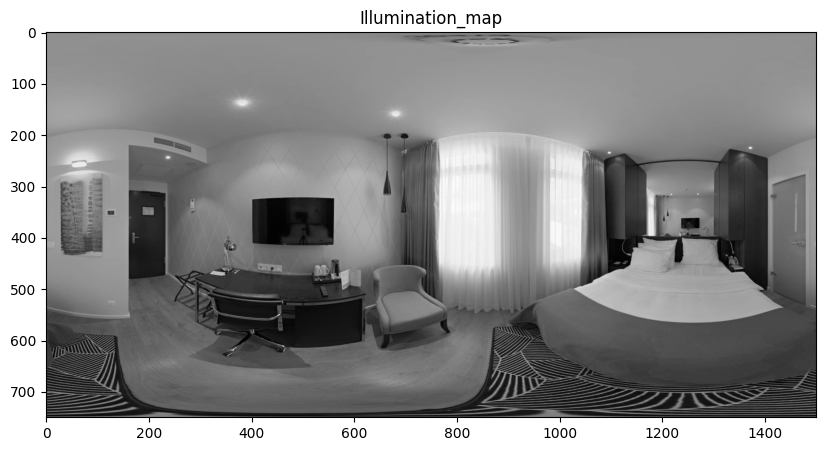

areas done


: 

In [15]:
hdr_image = load_hdr_image(file_path)
hdr_tensor = np.array(hdr_image)
hdr_tensor = normalize_image(hdr_tensor)

R = hdr_tensor[:, :, 0]
G = hdr_tensor[:, :, 1]
B = hdr_tensor[:, :, 2]  

I_map = illumination_map(hdr_image)
display_image(I_map, title='Illumination_map', cmap='gray')

A = angular_areas(hdr_image)
print("areas done")
height, width, _ = hdr_image.shape
N = surface_normals((height, width))
print("surface normals done")
kd = 0.8
ks = 0.5
n = 10
D = diffuse_reflection(I_map, N, A, kd)
print("diffusion done")
S = specular_reflection(I_map, N, A, ks, n)
intensity = output_intensity(D, S, N)

print(hdr_image.shape)
print(hdr_tensor.shape)
print(I_map.shape)
print(A.shape)
print(N.shape)
print(D.shape)
print(S.shape)
print(intensity.shape)

display_image(hdr_tensor, title='Actual Image', cmap='gray')
display_image(R, title='R Channel', cmap='Reds')
display_image(G, title='G Channel', cmap='Greens')
display_image(B, title='B Channel', cmap='Blues')
display_image(I_map, title='Illumination_map', cmap='gray')
display_image(intensity, title='Final Image', cmap=None)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os

def load_hdr_image(file_path):
    hdr_image = Image.open(file_path)
    hdr_image = np.array(hdr_image).astype(np.float32)
    return hdr_image

def display_image(image, title='', cmap=None):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('on')
    # plt.colorbar()
    plt.show()

def normalize_image(image):
    image = image - np.min(image)
    image = image / np.max(image)
    return image

def illumination_map(hdr_image):
    hdr_image_normalized = normalize_image(hdr_image)
    luminance_map = np.mean(hdr_image_normalized, axis=-1)

    return luminance_map

def surface_normals(shape):
    height, width = shape
    surface_normals = np.zeros((height, width, 3), dtype=np.float32)
    
    for i in range(height):
        for j in range(width):
            N = np.array([np.sin(np.pi * i / height) * np.cos(2 * np.pi * j / width),
                          np.sin(np.pi * i / height) * np.sin(2 * np.pi * j / width),
                          np.cos(np.pi * i / height)])
            surface_normals[i, j] = N
            
    return surface_normals

def angular_areas(hdr_image):
    height, width, _ = hdr_image.shape
    dtheta = np.pi / height
    dphi = 2 * np.pi / width
    
    areas = np.zeros((height, width))
    for i in range(height):
        theta = (i + 0.5) * dtheta - np.pi / 2
        sin_theta = np.sin(theta)
        areas[i, :] = sin_theta * dtheta * dphi
    
    return areas

def fd(N_dot_L, kd):
    if N_dot_L > 0:
        return kd * N_dot_L
    return 0

# def diffuse_reflection(I, N, A, kd):
#     height, width = I.shape
#     D = np.zeros((height, width, 3), dtype=np.float32)
#     for i in range(height):
#         print("hi")
#         for j in range(width):
#             if j%10 == 0:
#                 print("hello")
#             for l in range(height):
#                 for m in range(width):
#                     L = N[l, m]
#                     N_dot_L = np.dot(N[i, j], L)
#                     for c in range(3):
#                         D[i, j, c] += I[l, m] * A[l, m] * fd(N_dot_L, kd)
#             D[i, j] /= (4 * np.pi)
#     return D

def diffuse_reflection(I, N, A, kd):
    height, width = I.shape
    D = np.zeros((height, width, 3), dtype=np.float32)
    
    # Reshape N to (height*width, 3) to make it easier to compute dot products
    N_reshaped = N.reshape(-1, 3)
    print("N_reshaped done")
    # Precompute dot products between all normal vectors
    N_dot_L = np.dot(N_reshaped, N_reshaped.T)
    print("N_dot_L done")
    # Compute the diffuse reflection using broadcasting
    for c in range(3):
        print("hi")
        D[:, :, c] = np.sum(I[:, :, None] * A[:, :, None] * fd(N_dot_L, kd).reshape(height, width), axis=(1, 2))
    print("for done")
    D /= (4 * np.pi)
    return D

def fs_phong_specular(N_dot_R, ks, n):
    if N_dot_R > 0:
        return ks * (N_dot_R ** n)
    return 0

# def specular_reflection(I, N, A, ks, n):
#     height, width = I.shape
#     S = np.zeros((height, width, 3), dtype=np.float32)
    
#     for i in range(height):
#         for j in range(width):
#             for l in range(height):
#                 for m in range(width):
#                     L = N[l, m]
#                     R = 2 * np.dot(N[i, j], L) * N[i, j] - L
#                     N_dot_R = np.dot(N[i, j], R)
#                     specular_value = fs_phong_specular(N_dot_R, ks, n)
#                     for c in range(3):
#                         S[i, j, c] += I[l, m] * A[l, m] * specular_value
#             S[i, j] /= (4 * np.pi)
#     return S

def specular_reflection(I, N, A, ks, n):
    height, width = I.shape
    S = np.zeros((height, width, 3), dtype=np.float32)
    
    # Reshape N to (height*width, 3) for easier vector operations
    N_reshaped = N.reshape(-1, 3)
    
    # Compute dot products between all normal vectors
    N_dot_L = np.dot(N_reshaped, N_reshaped.T)
    
    # Calculate the reflection vectors R for all pairs
    R = 2 * N_dot_L[:, :, None] * N_reshaped[:, None, :] - N_reshaped[None, :, :]
    R = R.reshape(height, width, height, width, 3)
    
    # Compute dot products of normal vectors with reflection vectors
    N_dot_R = np.einsum('ijkl,ijkl->ij', N.reshape(height, width, 1, 1, 3), R)
    
    # Compute the specular reflection values
    specular_values = fs_phong_specular(N_dot_R, ks, n)
    
    # Accumulate the specular reflection across all pixels
    for c in range(3):
        S[:, :, c] = np.sum(I[:, :, None] * A[:, :, None] * specular_values, axis=(1, 2))
    
    S /= (4 * np.pi)
    return S

def output_intensity(D, S, N):
    height, width, _ = D.shape
    intensity = np.zeros_like(D)
    
    Wd = 0.7
    Ws = 0.3
    
    # Precompute the viewing direction and reflection vectors for all pixels
    E = np.array([0, 0, 1])
    N_dot_E = np.einsum('ijk,k->ij', N, E)
    R = 2 * N_dot_E[:, :, None] * N - E
    
    # Calculate the weighted sum of diffuse and specular reflection
    intensity = Wd * N_dot_E[:, :, None] * D + Ws * N_dot_E[:, :, None] * S
    
    # Normalize the intensity values
    intensity_min = intensity.min()
    intensity_max = intensity.max()
    intensity_normalized = (intensity - intensity_min) / (intensity_max - intensity_min)
    
    return intensity_normalized

# def output_intensity(D, S, N):
#     height, width = D.shape
#     intensity = np.zeros_like(D)
    
#     Wd = 0.7
#     Ws = 0.3
    
#     for i in range(height):
#         for j in range(width):
#             E = np.array([0, 0, 1])
#             R = 2 * np.dot(E, N[i, j]) * N[i, j] - E
#             N_dot_E = np.dot(N[i, j], E)
#             for c in range(3):
#                 output_intensity[i, j, c] = Wd * N_dot_E * D[i, j, c] + Ws * N_dot_E * S[i, j, c]

#     intensity_normalized = (intensity - intensity.min()) / (intensity.max() - intensity.min())
    
#     return intensity_normalized

print(os.getcwd())  # This will print the current working directory
file_path = os.path.abspath('samples/img/test2.hdr')
print(file_path)
hdr_image = load_hdr_image(file_path)
hdr_tensor = np.array(hdr_image)
hdr_tensor = normalize_image(hdr_tensor)

R = hdr_tensor[:, :, 0]
G = hdr_tensor[:, :, 1]
B = hdr_tensor[:, :, 2]  

I_map = illumination_map(hdr_image)
display_image(I_map, title='Illumination_map', cmap='gray')

A = angular_areas(hdr_image)
print("areas done")
height, width, _ = hdr_image.shape
N = surface_normals((height, width))
print("surface normals done")
kd = 0.8
ks = 0.5
n = 10
D = diffuse_reflection(I_map, N, A, kd)
print("diffusion done")
S = specular_reflection(I_map, N, A, ks, n)
intensity = output_intensity(D, S, N)

print(hdr_image.shape)
print(hdr_tensor.shape)
print(I_map.shape)
print(A.shape)
print(N.shape)
print(D.shape)
print(S.shape)
print(intensity.shape)

display_image(hdr_tensor, title='Actual Image', cmap='gray')
display_image(R, title='R Channel', cmap='Reds')
display_image(G, title='G Channel', cmap='Greens')
display_image(B, title='B Channel', cmap='Blues')
display_image(I_map, title='Illumination_map', cmap='gray')
display_image(intensity, title='Final Image', cmap=None)
